# import

In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import average_precision_score,roc_auc_score

# Draw_box_plot 

In [347]:
def draw_plot(file_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1)
    to_plot=pd.read_csv('./edata/Save_for_drawing/'+file_name+'_box_plot.csv',index_col=None,sep=',')
    to_plot.replace({'modification':{0:'Unmodified',1:'Modified'}},inplace=True)
    fig,axes=plt.subplots(3,1,sharex=True,sharey=True)
    count=0
    for ax,features_to_plot in zip(axes,['event_stdv','event_mean','event_length']):
        sub_to_plot=to_plot[to_plot['feature']==features_to_plot].copy()
        LEN=len(sub_to_plot)
        sub_to_plot.sort_values(by='value',inplace=True)
        sub_to_plot=sub_to_plot.loc[sub_to_plot.index[int(LEN*0.1):int(LEN*0.9)]]
        sub_to_plot.value=(sub_to_plot.value-min(sub_to_plot.value))/(max(sub_to_plot.value)-min(sub_to_plot.value))    
        sns.boxplot(x='position',y='value',hue='modification',data=sub_to_plot,ax=ax,showfliers=False)#palette="Blues_d")
        if count==0:
            ax.set_title('Feature of '+file_name[-5:],fontsize=20)
        ax.set_ylabel('Normalized '+features_to_plot[6:],fontsize=10)
        ax.yaxis.set_label_position("left")
        ax.yaxis.set_tick_params(labelsize=12)
        ax.legend([],[],frameon=False)
        ax.set_xlabel('')
        count+=1
    handles,labels=ax.get_legend_handles_labels()
    ax.set_xlabel("Position",fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    fig.legend(handles,labels,loc="center right",fontsize=10)
    plt.tight_layout(pad=1)
    fig.savefig('./edata/Save_drawing/'+file_name+'_Boxplots.pdf',bbox_inches='tight')

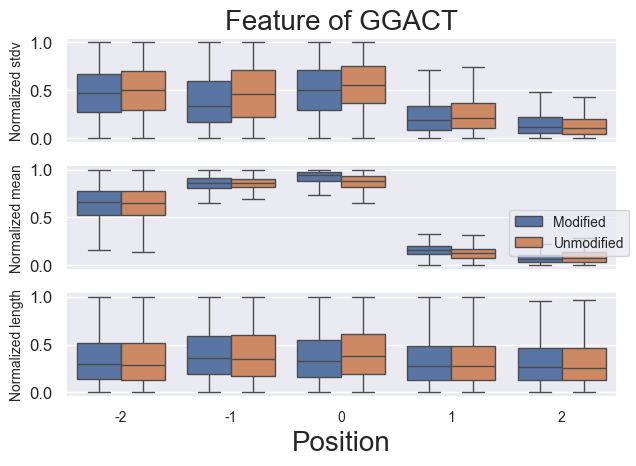

In [348]:
draw_plot('m6A_GGACT')

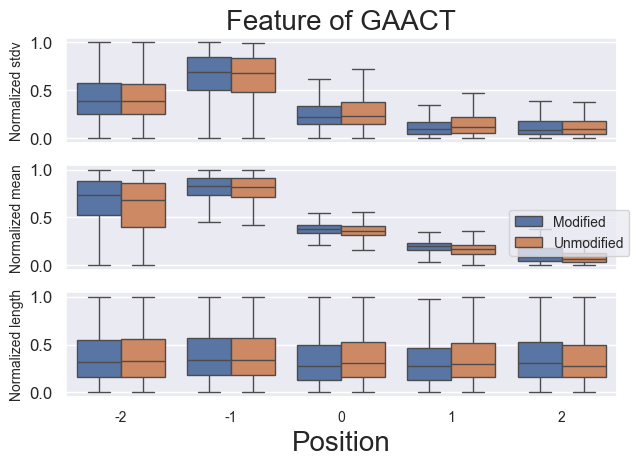

In [349]:
draw_plot('m6A_GAACT')

# Draw_curve

In [2]:
def draw_curve(label_pre_lis,s_name,no_dash_line=0):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    keep=[]
    for c_name in label_pre_lis:
        read_frame=pd.read_csv('./edata/Save_for_drawing/'+c_name+'_curve.csv')
        keep.append((c_name,np.array(read_frame['label']),np.array(read_frame['pred'])))
        
    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        plt.plot(roc_x,roc_y,lw=2,label=each[0]+' (area = %0.3f)'%roc_auc_score(each[1],each[2]))
    if no_dash_line==0:
        plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    fontsize=16
    plt.xlabel('False Positive Rate',fontsize=fontsize+4)
    plt.ylabel('True Positive Rate',fontsize=fontsize+4)
    plt.legend(loc="lower right")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_ROC.pdf',bbox_inches='tight')
    plt.show()

    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        preci,recall,_=precision_recall_curve(each[1],each[2])    
        plt.plot(recall,preci,lw=2,label=each[0]+' (area = %0.3f)'%average_precision_score(each[1],each[2]))
    plt.xlabel('Recall',fontsize=fontsize+4)
    plt.ylabel('Precision', fontsize=fontsize+4)
    plt.legend(loc="lower left")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_PR.pdf',bbox_inches='tight')
    plt.show()

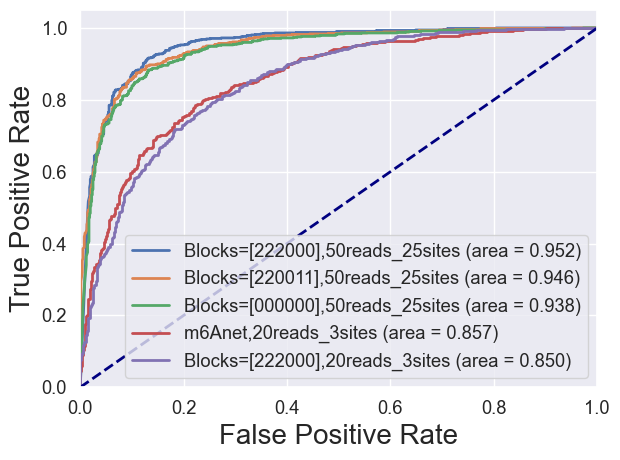

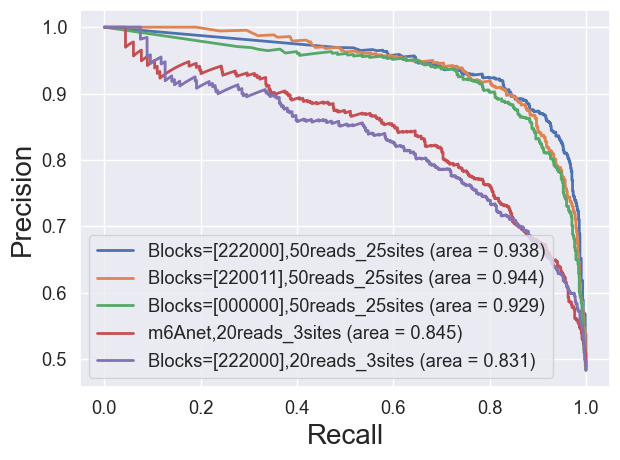

In [383]:
draw_curve(['Blocks=[222000],50reads_25sites','Blocks=[220011],50reads_25sites','Blocks=[000000],50reads_25sites',\
           'm6Anet,20reads_3sites','Blocks=[222000],20reads_3sites'],'main')

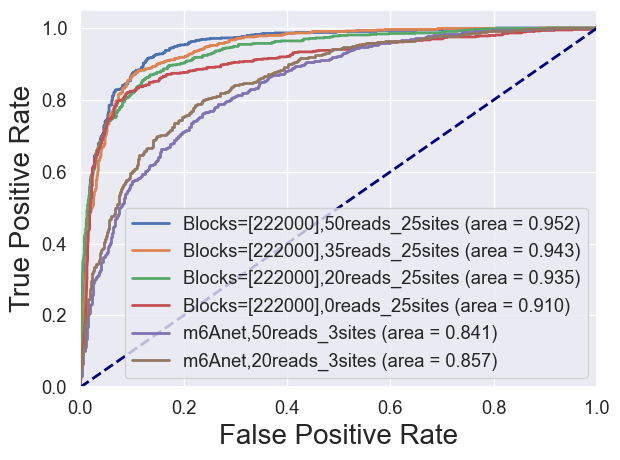

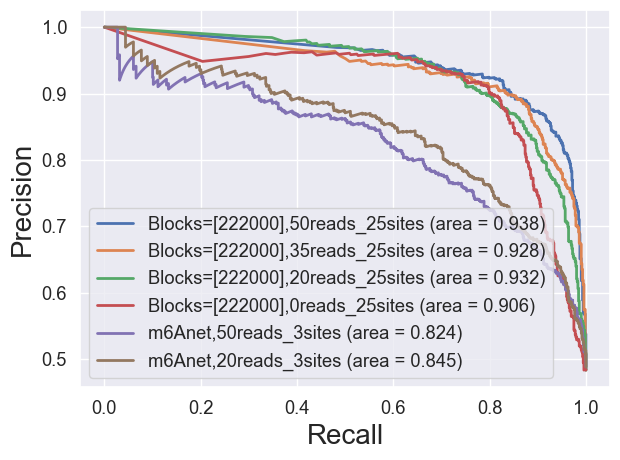

In [385]:
draw_curve(['Blocks=[222000],50reads_25sites','Blocks=[222000],35reads_25sites','Blocks=[222000],20reads_25sites','Blocks=[222000],0reads_25sites',\
           'm6Anet,50reads_3sites','m6Anet,20reads_3sites'],'Reads_Dif')

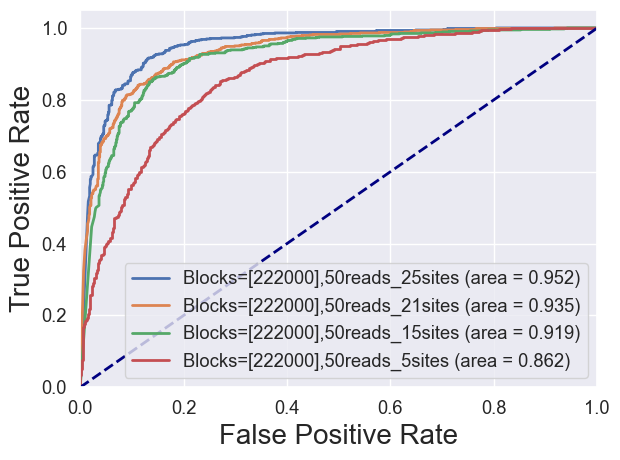

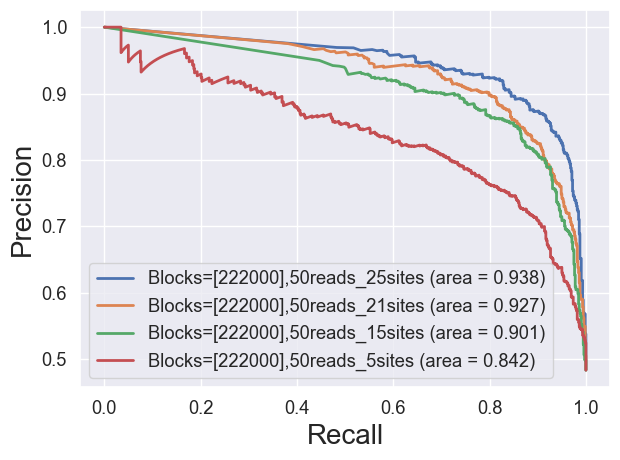

In [386]:
draw_curve(['Blocks=[222000],50reads_25sites','Blocks=[222000],50reads_21sites','Blocks=[222000],50reads_15sites','Blocks=[222000],50reads_5sites'],'Sites_Dif')

# Draw_top_curve

In [334]:
from matplotlib.ticker import FuncFormatter
def to_percent(temp,position):
    return '%0.0f'%(100*temp)+'%'
def int_func(temp,position):
    return str(int(temp))
def draw_top_curve(label_pre_lis,s_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    fontsize=16
    keep=[]
    for c_name in label_pre_lis:
        read_frame=pd.read_csv('./edata/Save_for_drawing/'+c_name+'_curve.csv')
        read_frame=read_frame.sort_values(by='pred',ascending=False).reset_index(drop=True)
        read_frame['top_percent']=np.array(range(1,len(read_frame)+1))/len(read_frame)
        read_frame=read_frame[read_frame.top_percent<=0.3]
        precision_till_now=[]
        for i in range(len(read_frame)):
            precision_till_now.append(read_frame.label[:i+1].sum()/(i+1))
        read_frame['precision_till_now']=precision_till_now
        points_near=[0.1,0.2,0.3]
        points,points_val=[],[]
        for each in points_near:
            point=np.argmin(abs(read_frame['top_percent']-each))
            points.append(point)
            points_val.append(read_frame['top_percent'][point])
        X=read_frame['top_percent'][np.array(read_frame.index%10==0) | np.array(read_frame.index==points[0]) | np.array(read_frame.index==points[1]) | np.array(read_frame.index==points[2])]
        Y=read_frame['precision_till_now'][np.array(read_frame.index%10==0) | np.array(read_frame.index==points[0]) | np.array(read_frame.index==points[1]) | np.array(read_frame.index==points[2])]
        mark_pos=[]
        for each in points_val:
            mark_pos.append(np.argmin(abs(X-each)))
        plt.plot(X,Y,label=c_name,marker='o',markevery=mark_pos)
        for i in range(len(points_near)):
            text_offset=(-15,10)
            ##customized adjustment for aesthetic
            if abs(Y.iloc[mark_pos[i]]-0.953)<=0.001:
                text_offset=(-15,-18)
            elif abs(Y.iloc[mark_pos[i]]-0.963)<=0.001:
                text_offset=(-15,5)
            plt.annotate('%.3f'%Y.iloc[mark_pos[i]],xy=(X.iloc[mark_pos[i]],Y.iloc[mark_pos[i]]),xytext=text_offset,textcoords='offset points',fontsize=fontsize,weight='bold')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.xlabel('Percent of top scored sites',fontsize=fontsize+4)
    plt.ylabel('Precision',fontsize=fontsize+4)
    plt.legend(loc="lower left")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_TOP.pdf',bbox_inches='tight')
    plt.show()
    
    #top 300
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1)
    for c_name in label_pre_lis:
        read_frame=pd.read_csv('./edata/Save_for_drawing/'+c_name+'_curve.csv')
        read_frame=read_frame.sort_values(by='pred',ascending=False).reset_index(drop=True)
        print(len(read_frame))
        read_frame=read_frame[:301]
        precision_till_now=[]
        for i in range(len(read_frame)):
            precision_till_now.append(read_frame.label[:i+1].sum()/(i+1))
        read_frame['precision_till_now']=precision_till_now
        X=np.arange(0,301,10)
        Y=read_frame['precision_till_now'][X]
        mark_pos=[10,20,30]
        plt.plot(X,Y,label=c_name,marker='o',markevery=mark_pos)
        for i in range(3):
            text_offset=(-15,10)
            plt.annotate('%.3f'%Y.iloc[mark_pos[i]],xy=(X[mark_pos[i]],Y.iloc[mark_pos[i]]),xytext=text_offset,textcoords='offset points',fontsize=fontsize,weight='bold')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(int_func))
    plt.xlabel('Number of top scored sites',fontsize=fontsize+4)
    plt.ylabel('Precision',fontsize=fontsize+4)
    plt.legend(loc="lower left")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_TOP_NUM.pdf',bbox_inches='tight')
    plt.show()

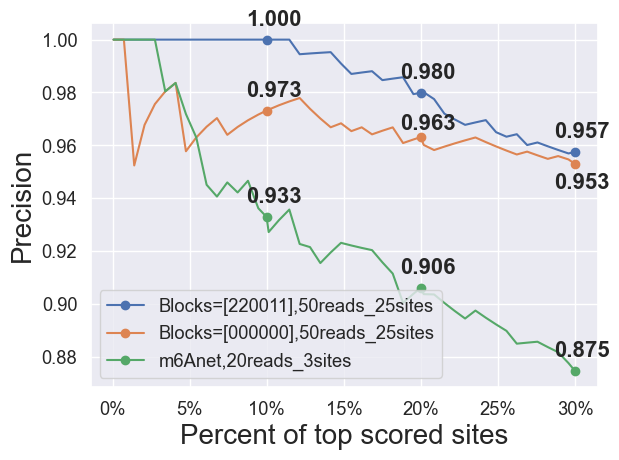

1492
1492
1492


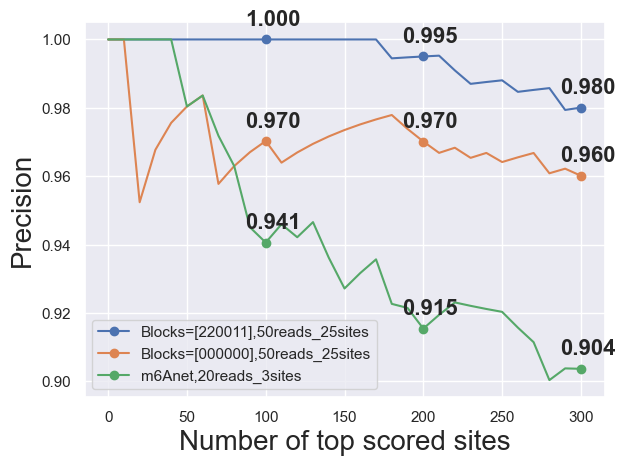

In [335]:
draw_top_curve(['Blocks=[220011],50reads_25sites','Blocks=[000000],50reads_25sites','m6Anet,20reads_3sites'],'main')

# Draw_motif_histo

In [365]:
def draw_motif_histo(label_pre,s_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    read_frame=pd.read_csv('./edata/Save_for_drawing/'+label_pre+'_motif_histo.csv',index_col=0)
    read_frame.index.name='Motifs'
    read_frame['Total Count']=read_frame['TP']+read_frame['TN']+read_frame['FP']+read_frame['FN']
    read_frame=read_frame.sort_values(by='Total Count',ascending=False)

    TP_read_frame=read_frame.copy()
    TP_read_frame.insert(loc=4,column='Prediction',value='TP')
    TP_read_frame.insert(loc=5,column='Count',value=TP_read_frame['TP'])
    TN_read_frame=read_frame.copy()
    TN_read_frame.insert(loc=4,column='Prediction',value='TN')
    TN_read_frame.insert(loc=5,column='Count',value=TN_read_frame['TN'])
    T_frame=pd.concat([TP_read_frame,TN_read_frame])
    
    FN_read_frame=read_frame.copy()
    FN_read_frame.insert(loc=4,column='Prediction',value='FN')
    FN_read_frame.insert(loc=5,column='Count',value=FN_read_frame['FN'])
    FP_read_frame=read_frame.copy()
    FP_read_frame.insert(loc=4,column='Prediction',value='FP')
    FP_read_frame.insert(loc=5,column='Count',value=FP_read_frame['FP'])
    F_frame=pd.concat([FN_read_frame,FP_read_frame])
    
    T_frame['Percent']=T_frame['Count']/(T_frame['Count']+F_frame['Count'])
    F_frame['Percent']=F_frame['Count']/(T_frame['Count']+F_frame['Count'])
    T_frame=T_frame.fillna(0)
    F_frame=F_frame.fillna(0)
    
    F_frame['Count']+=T_frame['Count']
    F_frame['Percent']+=T_frame['Percent']

    plt.figure(figsize=[12,9])
    sns.barplot(x='Motifs',y='Count',hue='Prediction',data=F_frame,palette='Reds_d')
    sns.barplot(x='Motifs',y='Count',hue='Prediction',data=T_frame,palette='Blues_d')
    plt.legend(loc="upper right",fontsize=18)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=16)
    plt.xlabel('Motifs',fontsize=22)
    plt.ylabel('Count',fontsize=22)
    plt.tight_layout(pad=5)
    plt.savefig('./edata/Save_drawing/'+s_name+'_motif_Count.pdf',bbox_inches='tight')
    plt.show()
    '''
    plt.figure(figsize=[12,9])
    sns.barplot(x='Motifs',y='Percent',hue='Prediction',data=F_frame,palette='Reds_d')
    sns.barplot(x='Motifs',y='Percent',hue='Prediction',data=T_frame,palette='Blues_d')
    plt.legend(loc="upper right",fontsize=18)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=16)
    plt.xlabel('Motifs',fontsize=22)
    plt.ylabel('Percent',fontsize=22)
    plt.tight_layout(pad=5)
    plt.savefig('./edata/Save_drawing/'+s_name+'_motif_Percent.pdf',bbox_inches='tight')
    plt.show()'''

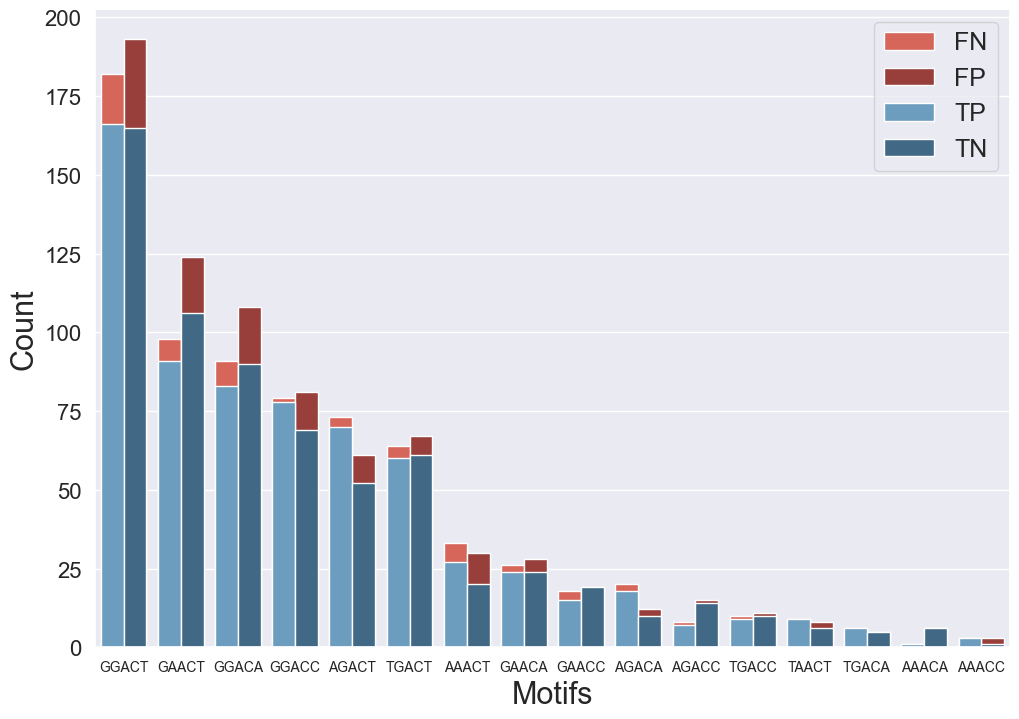

In [366]:
draw_motif_histo('Blocks=[222000],50reads_25sites','Conventional')

# Draw_range_histo

In [332]:
def draw_range_histo(label_pre,s_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    read_frame=pd.read_csv('./edata/Save_for_drawing/'+label_pre+'_range_histo.csv')
    Copy=read_frame.loc[:,'Ground Truth'].copy()
    Copy[read_frame['Ground Truth']==0]='Unmodified'
    Copy[read_frame['Ground Truth']==1]='Modified'
    read_frame['Ground Truth']=Copy
    LEN=len(Copy)
    W=np.array([1/LEN]*LEN)
    print(W)
    sns.displot(data=read_frame,x='Probability score',hue='Ground Truth',bins=np.linspace(0,1,11),kde=True,weights=1/LEN)
    plt.xlabel('Probability score',fontsize=18)
    plt.ylabel('Proportion',fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig('./edata/Save_drawing/'+s_name+'_score_distribution.pdf',bbox_inches='tight')
    plt.show()

[0.00067024 0.00067024 0.00067024 ... 0.00067024 0.00067024 0.00067024]


C:\Users\Faded\.conda\envs\jupyter\Lib\site-packages\seaborn\distributions.py:404: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


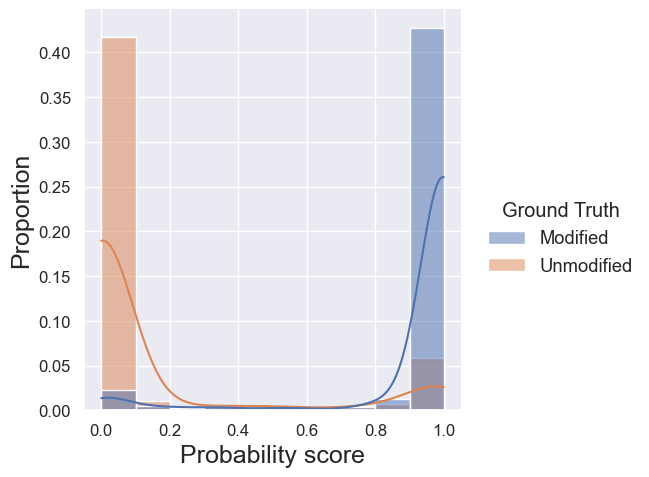

In [333]:
draw_range_histo('Blocks=[222000],50reads_25sites','Conventional')

# m5C

In [3]:
def draw_curve2(label_pre_lis,s_name,no_dash_line=0):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1)
    keep=[]
    for c_name in label_pre_lis:
        read_frame=pd.read_csv('./edata/Save_for_drawing/'+c_name+'_curve.csv')
        keep.append((c_name,np.array(read_frame['label']),np.array(read_frame['pred'])))
        
    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        plt.plot(roc_x,roc_y,lw=2,label=each[0]+' (area = %0.3f)'%roc_auc_score(each[1],each[2]))
    if no_dash_line==0:
        plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    fontsize=16
    plt.xlabel('False Positive Rate',fontsize=fontsize+4)
    plt.ylabel('True Positive Rate',fontsize=fontsize+4)
    plt.legend(loc="lower right")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_ROC.pdf',bbox_inches='tight')
    plt.show()

    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        preci,recall,_=precision_recall_curve(each[1],each[2])    
        plt.plot(recall,preci,lw=2,label=each[0]+' (area = %0.3f)'%average_precision_score(each[1],each[2]))
    plt.xlabel('Recall',fontsize=fontsize+4)
    plt.ylabel('Precision', fontsize=fontsize+4)
    plt.legend(loc="lower left")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_PR.pdf',bbox_inches='tight')
    plt.show()

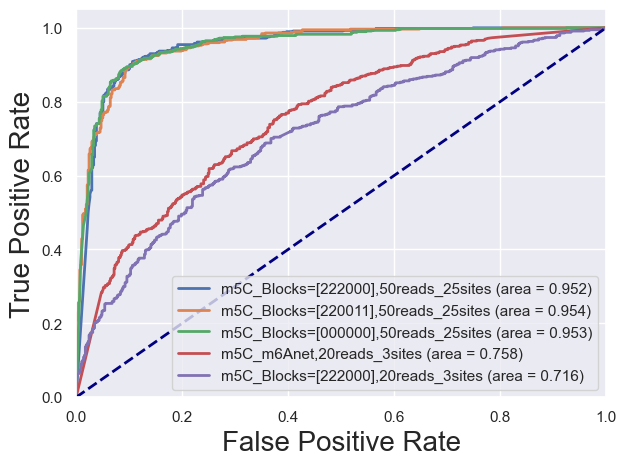

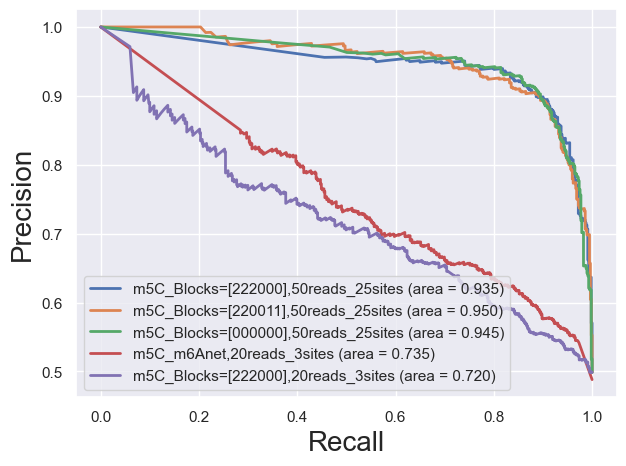

In [9]:
draw_curve2(['m5C_Blocks=[222000],50reads_25sites','m5C_Blocks=[220011],50reads_25sites','m5C_Blocks=[000000],50reads_25sites',\
             'm5C_m6Anet,20reads_3sites','m5C_Blocks=[222000],20reads_3sites'],'m5C')